In [1]:
!tree ../dataset

../dataset
├── en_espanol
│   ├── docx2txt.py
│   ├── Второй_жанр_исходная.txt
│   └── Первый_жанр_исходная.txt
├── Второй_жанр_исходная.txt
├── Первый_жанр_исходная.txt
├── Сокращение по частям речи
│   ├── 1.Первый жанр исходная выборка.txt
│   ├── 2.Первый жанр без клауз, включающих наречия.txt
│   ├── 3.Первый жанр без клауз, включающих глаголы.txt
│   ├── 4.Первый жанр без клауз, включающих глаголы и наречия.txt
│   ├── Без прилагательных второй жанр.txt
│   ├── Без прилагательных первый жанр.txt
│   └── Случайные выборки.txt
└── сокращение по частотности
    ├── 1а_ без сокращений.txt
    ├── 1б_Изъяты лексемы с частотой выше 100.txt
    ├── 1в_Изъяты лексемы с частотой выше 49.txt
    ├── 1г_Изъяты лексемы с частотой выше 29.txt
    ├── 1д_Изъяты лексемы с частотой выше 9.txt
    ├── 1е_Изъяты лексемы с частотой выше 5.txt
    ├── 1ё_Изъяты лексемы с частотой выше 3.txt
    ├── 2а_ без сокращений.txt
    ├── 2б_Изъяты лексемы с частотой выше 100.txt
    ├── 2в_Изъяты лексемы с ч

In [2]:
ls

 __pycache__/                          model_results.json
 confronto_prestazioni.png             model_results_GPT.json
 frecuencia.png                        model_results_GPT_bert.json
 frecuencia_lineas.png                 parte_2.png
 frecuencia_profesional.png            parte_2_Step1.png
 frecuencia_profesional_ajustada.png   partes_discurso.png
 frecuencia_step_1.png                 performance_comparison_other.png
 frecuencia_test_1.png                 plots/
 freq_analysis.png                     pos_analysis.png
 freq_comparison.png                   utils.py
 funciones.py                          wandb/
 generador.ipynb                      'сокращение по частотности'/
 herramientas.ipynb                   'сокращение по частотности.ipynb'
 loss_comparison.png


In [3]:
import json

def save_results(results, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=4, ensure_ascii=False)

In [4]:
import funciones
from utils import train_wrapper
import warnings
import os
import torch
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
from contextlib import redirect_stderr
import multiprocessing as mp
import numpy as np
#import wandb
import nbformat
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from sklearn.metrics import classification_report, confusion_matrix
import gc
import re
import nltk
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification, AdamW
from razdel import sentenize
import numpy as np

# Suprimir warnings específicos
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
mp.set_start_method('spawn', force=True)


import json

def save_results(results, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=4, ensure_ascii=False)
# import funciones
# from utils import train_wrapper
# import warnings
# import os
# import torch
# import matplotlib.pyplot as plt

# # Suprimir warnings específicos
# warnings.filterwarnings('ignore', category=UserWarning)  # Para sklearn y otros
# warnings.filterwarnings('ignore', category=FutureWarning)  # Para huggingface y transformers
# from concurrent.futures import ProcessPoolExecutor
# from tqdm import tqdm
# from contextlib import redirect_stderr
# from concurrent.futures import ProcessPoolExecutor
# import multiprocessing as mp
# import numpy as np
# mp.set_start_method('spawn', force=True)
# #os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

###############################################################################
# import wandb
# import nbformat
# # Configurar la clave de la API como variable de entorno
# os.environ["WANDB_API_KEY"] = "ca85316ed713b2425615fb3a613d7eb414c9f57f"  # Reemplaza con tu clave
# # Iniciar wandb sin especificar entity (se detecta automáticamente)
# wandb.init(project="model-clasification")
# wandb.init(
#     settings=wandb.Settings(
#         start_method="thread",
#         timeout=30,
#         sync_dir="/tmp/wandb",  # Usa un directorio temporal
#         disable_code=True       # Mejora la estabilidad
#     )
# )
#os.environ["WANDB_NOTEBOOK_NAME"] = "сокращение по частотности.ipynb"
###############################################################################


def create_custom_config(model_name, model_type, dataset):
    """Crea configuración de entrenamiento adaptativa"""
    common_config = {
#         'dataset_name':dataset.get('name', ''),
        'model_name': model_name,
        'model_type': model_type,
        'num_repeats': 6,
        'test_size': 0.2,
        'threshold': 0.5
    }

    # Configuración específica para GPT
    if model_type == 'gpt':
        return funciones.TrainingConfig(
            **common_config,
            max_length=512,
            batch_size=4,
            epochs=2,
            learning_rate=1e-5
        )

    # Configuraciones basadas en frecuencia
    freq_threshold = dataset.get('freq_threshold')
    if freq_threshold in [100, 49, 29, 9, 5, 3]:
        configs = {
            100: (52, 128, 3, 2e-5),
            49: (60, 128, 4, 3e-5),
            29: (51, 128, 4, 3e-5),
            9: (45, 128, 5, 4e-5),
            5: (150, 32, 6, 5e-5),
            3: (150, 32, 6, 5e-5)
        }
        max_len, batch, epochs, lr = configs[freq_threshold]
        return funciones.TrainingConfig(
            **common_config,
            max_length=max_len,
            batch_size=batch,
            epochs=epochs,
            learning_rate=lr
        )

    # Configuración por nombre de dataset
    dataset_name = dataset.get('name', '')
    if any(x in dataset_name for x in ['1', '2', '3', '4']):
        return funciones.TrainingConfig(
            **common_config,
            max_length=60,
            batch_size=128,
            epochs=6,
            learning_rate=5e-5
        )

    # Configuración por defecto
    return funciones.TrainingConfig(
        **common_config,
        max_length=60,
        batch_size=128,
        epochs=4,
        learning_rate=3e-5
    )

models = [
#         {'model':'DeepPavlov/rubert-base-cased',
#          'name':'DeepPavlov-rubert-base',
#          'type': 'bert'},# Modelo original
#         {'model':'bert-base-multilingual-cased',
#          'name':'BERT multilingual',
#          'type': 'bert'},# BERT multilingüe
        {'model':'distilbert-base-multilingual-cased',
         'name':'distilbert-base-multilingual',
         'type': 'bert'},# Versión ligera de BERT
#         {'model':'roberta-base',
#          'name':'roberta-base', 
#         'type': 'bert'}, # RoBERTa 
        {'model': 'gpt2',
         'name': 'gpt2',
         'type': 'gpt'},  #  GPT model
#         {'model': 'facebook/opt-125m',
#          'name': 'facebook',
#          'type': 'gpt'},  #  GPT model
#         {'model': 'sberbank-ai/rugpt3small_based_on_gpt2',
#          'name': 'rugpt3',
#          'type': 'gpt'}
    ]

datasets = [
        {
            'path1': '../dataset/сокращение по частотности/1б_Изъяты лексемы с частотой выше 100.txt',
            'path2': '../dataset/сокращение по частотности/2б_Изъяты лексемы с частотой выше 100.txt',
            'name': 'Изъяты лексемы с частотой выше 100',
            'type': 'freq',
            'freq': 100
        },
#         {
#             'path1': '../dataset/сокращение по частотности/1в_Изъяты лексемы с частотой выше 49.txt',
#             'path2': '../dataset/сокращение по частотности/2в_Изъяты лексемы с частотой выше 49.txt',
#             'name': 'Изъяты лексемы с частотой выше 49',
#             'type': 'freq',
#             'freq': 49
#         },
#         {
#             'path1': '../dataset/сокращение по частотности/1г_Изъяты лексемы с частотой выше 29.txt',
#             'path2': '../dataset/сокращение по частотности/2г_Изъяты лексемы с частотой выше 29.txt',
#             'name': 'Изъяты лексемы с частотой выше 29',
#             'type': 'freq',
#             'freq': 29
#         },
#         {
#             'path1': '../dataset/сокращение по частотности/1д_Изъяты лексемы с частотой выше 9.txt',
#             'path2': '../dataset/сокращение по частотности/2д_Изъяты лексемы с частотой выше 9.txt',
#             'name': 'Изъяты лексемы с частотой выше 9',
#             'type': 'freq',
#             'freq': 9
#         },
#         {
#             'path1': '../dataset/сокращение по частотности/1е_Изъяты лексемы с частотой выше 5.txt',
#             'path2': '../dataset/сокращение по частотности/2е_Изъяты лексемы с частотой выше 5.txt',
#             'name': 'Изъяты лексемы с частотой выше 5',
#             'type': 'freq',
#             'freq': 5
#         },
#         {
#             'path1': '../dataset/сокращение по частотности/1ё_Изъяты лексемы с частотой выше 3.txt',
#             'path2': '../dataset/сокращение по частотности/2ё_Изъяты лексемы с частотой выше 3.txt',
#             'name': 'Изъяты лексемы с частотой выше 3',
#             'type': 'freq',
#             'freq': 3
#         },

#             {
#             'path1': '../dataset/Сокращение по частям речи/Без прилагательных первый жанр.txt',
#             'path2': '../dataset/Сокращение по частям речи/Без прилагательных второй жанр.txt',
#             'name': 'Без прилагательных второй жанр',
#             'type': 'pos',
#             'freq': None
#             },
#           {
#             'path1': '../dataset/Сокращение по частям речи/1.Первый жанр исходная выборка.txt',
#             'path2': '../dataset/Второй_жанр_исходная.txt',
#             'name': '1.Первый жанр исходная выборка',
#             'type': 'pos',
#             'freq': None

#         },
#         {
#             'path1': '../dataset/Сокращение по частям речи/2.Первый жанр без клауз, включающих наречия.txt',
#             'path2': '../dataset/Второй_жанр_исходная.txt',
#             'name': '2.Первый жанр без клауз, включающих наречия',
#             'type': 'pos',
#             'freq': None
#         },
#         {
#             'path1': '../dataset/Сокращение по частям речи/3.Первый жанр без клауз, включающих глаголы.txt',
#             'path2': '../dataset/Второй_жанр_исходная.txt',
#             'name': '3.Первый жанр без клауз, включающих глаголы',
#             'type': 'pos',
#             'freq': None
#         },
#         {
#             'path1': '../dataset/Сокращение по частям речи/4.Первый жанр без клауз, включающих глаголы и наречия.txt',
#             'path2': '../dataset/Второй_жанр_исходная.txt',
#             'name': '4.Первый жанр без клауз, включающих глаголы и наречия',
#             'type': 'pos',
#             'freq': None
#         },
    ]

def main():

    results = []
    for model in models:
        for dataset in datasets:
            config = create_custom_config(model['model'], model['type'], dataset)
            
            # Configurar wandb para este experimento
#             wandb_run = wandb.init(
#                 project="model-comparison",
#                 name=f"{dataset['name']} - {model['name']}",
#                 group=f"{dataset['type']}_{dataset.get('freq', 'base')}",
#                 config={
#                     "model": model['model'],
#                     "model_type": model['type'],
#                     "dataset": dataset['name'],
#                     "type": dataset['type'],
#                     "freq": dataset.get('freq', None),
#                     **config.__dict__
#                 },
#                 reinit=True
#             )
            
            # Entrenar y limpiar memoria
            torch.cuda.empty_cache()
            result = funciones.train_and_evaluate_dataset(
                dataset['path1'],
                dataset['path2'],
                config,
                dataset['name'],
                dataset['type']
                
#                 wandb_run=wandb_run
            )
            results.append(result) 
            
#             wandb.log({
#                 "final_avg_accuracy": result['avg_accuracy'],
#                 "final_std_accuracy": result['std_accuracy'],
#                 "final_avg_loss": result['avg_loss']
#             })
            
            # Crear tablas de resumen
#             summary_table = wandb.Table(columns=["Metric", "Value"])
#             summary_table.add_data("Avg Accuracy", result['avg_accuracy'])
#             summary_table.add_data("Std Accuracy", result['std_accuracy'])
#             summary_table.add_data("Avg Loss", result['avg_loss'])
            
#             wandb.log({
#                 f"summary/{dataset['name']}_{clean_model_name}": summary_table,
#                 "epoch": config.epochs  # Para alinear con otras métricas
#             })
            
#             wandb_run.finish()
        
    
    save_results(results, 'model_results_GPT_bert.json')    
#     funciones.plot_model_performance(datasets,
#                                      models,
#                                      results,
#                                      save_path='frecuencia_profesional.png'
#                                     )

    
    
if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


train_Изъяты лексемы с частотой выше 100.csv
test_Изъяты лексемы с частотой выше 100.csv
Train labels sample: tensor([1, 1, 1, 0, 0]), Shape: torch.Size([871])
Test labels sample: tensor([0, 0, 0, 0, 0]), Shape: torch.Size([190])
Epoch 1, Loss: 0.9122634955814907
Epoch 2, Loss: 0.6884850519044059
Epoch 3, Loss: 0.6760359832218715
Epoch 4, Loss: 0.662872348512922
Epoch 5, Loss: 0.6627428276198251
Epoch 6, Loss: 0.6533837488719395
all_preds shape: (190,)
all_labels shape: (190,)
all_probs shape: (190, 2)
Train labels sample: tensor([0, 0, 0, 0, 0]), Shape: torch.Size([871])
Test labels sample: tensor([0, 0, 0, 0, 0]), Shape: torch.Size([192])
Epoch 1, Loss: 0.8732698474611554
Epoch 2, Loss: 0.6922215649059841
Epoch 3, Loss: 0.6830473286764962
Epoch 4, Loss: 0.6756230337279183
Epoch 5, Loss: 0.6708924174308777
Epoch 6, Loss: 0.671423750264304
all_preds shape: (192,)
all_labels shape: (192,)
all_probs shape: (192, 2)
Train labels sample: tensor([0, 0, 1, 1, 1]), Shape: torch.Size([871])
Te

In [5]:
#batch_size=128

In [6]:
#display_results()

In [ ]:
import os
import IPython

# Reiniciar el kernel
IPython.display.display(IPython.display.Javascript("Jupyter.notebook.kernel.restart()"))

# Apagar el kernel después de reiniciar
os._exit(0)

In [ ]:
import matplotlib.font_manager
matplotlib.font_manager._rebuild()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

# Cargar resultados


with open('model_results_GPT_bert.json', 'r', encoding='utf-8') as f:
    results = json.load(f)

# Convertir a DataFrame
data = []
for result in results:
    data.append({
        'dataset_name': result['dataset_name'],
        'model_name': result['model_name'],
        'f1_weighted': result['avg_f1_weighted'],
        'f1_class1': result['avg_f1_class1'],
        'pr_auc': result['avg_pr_auc']
    })
df = pd.DataFrame(data)

# Gráfico de barras agrupadas
plt.figure(figsize=(10, 6))
sns.barplot(x='dataset_name', y='f1_weighted', hue='model_name', data=df)
plt.title('F1-Score Ponderado por Modelo y Dataset')
plt.xlabel('Dataset')
plt.ylabel('F1-Score Ponderado')
plt.xticks(rotation=45)
plt.legend(title='Modelo')
plt.tight_layout()
plt.show()

plt.style.use('seaborn-v0_8-whitegrid')  # Estilo limpio
sns.set_context('paper', font_scale=1.2)  # Escala para informes
sns.set_palette('colorblind')  # Paleta profesional y accesible
plt.rcParams['font.family'] = 'sans-serif'  # Usar familia genérica
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Helvetica', 'Arial']  # Priorizar fuentes disponibles
plt.rcParams['figure.dpi'] = 300  # Alta resolución
plt.rcParams['savefig.dpi'] = 300
# Similar para F1_class1
plt.figure(figsize=(10, 6))
sns.barplot(x='dataset_name', y='f1_class1', hue='model_name', data=df)
plt.title('F1-Score Clase Minoritaria (жанр1) por Modelo y Dataset')
plt.xlabel('Dataset')
plt.ylabel('F1-Score Clase 1')
plt.xticks(rotation=45)
plt.legend(title='Modelo')
plt.tight_layout()
plt.show()

# Opcional: Guardar en WandB
# import wandb
# wandb.init(project="model-comparison")
# wandb.log({"f1_weighted_plot": wandb.Image(plt)})

In [ ]:
def plot_model_comparison(df, output_dir='plots'):
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    # Gráfico para F1_weighted
    plt.figure(figsize=(10, 6))
    sns.barplot(x='dataset_name', y='f1_weighted', hue='model_name', data=df, 
                capsize=0.1, errwidth=1.5, errorbar=None)
    for i, model in enumerate(df['model_name'].unique()):
        model_data = df[df['model_name'] == model]
        plt.errorbar(x=np.arange(len(model_data)) + i*0.2 - 0.1, 
                     y=model_data['f1_weighted'], 
                     yerr=model_data['std_f1_weighted'], 
                     fmt='none', c='black', capsize=3)
    plt.title('Weighted F1-Score by Model and Dataset', fontsize=14, pad=15)
    plt.xlabel('Dataset', fontsize=12)
    plt.ylabel('Weighted F1-Score', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Model', loc='upper right', frameon=True)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/f1_weighted_comparison.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    
    # Gráfico para F1_class1
    plt.figure(figsize=(10, 6))
    sns.barplot(x='dataset_name', y='f1_class1', hue='model_name', data=df, 
                capsize=0.1, errwidth=1.5, errorbar=None)
    for i, model in enumerate(df['model_name'].unique()):
        model_data = df[df['model_name'] == model]
        plt.errorbar(x=np.arange(len(model_data)) + i*0.2 - 0.1, 
                     y=model_data['f1_class1'], 
                     yerr=model_data['std_f1_class1'], 
                     fmt='none', c='black', capsize=3)
    plt.title('F1-Score for Minority Class (жанр1) by Model and Dataset', fontsize=14, pad=15)
    plt.xlabel('Dataset', fontsize=12)
    plt.ylabel('F1-Score (жанр1)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Model', loc='upper right', frameon=True)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/f1_class1_comparison.pdf', format='pdf', bbox_inches='tight')
    plt.show()

In [ ]:
def plot_frequency_effect(df, output_dir='plots'):
    freq_data = df[df['dataset_name'].str.contains('Изъяты лексемы')]
    freq_data['freq'] = freq_data['dataset_name'].str.extract(r'выше (\d+)').astype(int)
    
    plt.figure(figsize=(10, 6))
    for model in freq_data['model_name'].unique():
        model_data = freq_data[freq_data['model_name'] == model].sort_values('freq')
        plt.plot(model_data['freq'], model_data['f1_class1'], marker='o', linewidth=2, label=f'{model} F1-Class1')
        plt.fill_between(model_data['freq'], 
                         model_data['f1_class1'] - model_data['std_f1_class1'], 
                         model_data['f1_class1'] + model_data['std_f1_class1'], 
                         alpha=0.2)
        plt.plot(model_data['freq'], model_data['pr_auc'], marker='s', linestyle='--', label=f'{model} PR-AUC')
        plt.fill_between(model_data['freq'], 
                         model_data['pr_auc'] - model_data['std_pr_auc'], 
                         model_data['pr_auc'] + model_data['std_pr_auc'], 
                         alpha=0.2)
    plt.title('Effect of Frequency Threshold on Metrics', fontsize=14, pad=15)
    plt.xlabel('Frequency Threshold', fontsize=12)
    plt.ylabel('Metric Value', fontsize=12)
    plt.xscale('log')
    plt.legend(loc='upper right', frameon=True)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/freq_effect.pdf', format='pdf', bbox_inches='tight')
    plt.show()

In [ ]:
def generate_professional_plots(results_file, output_dir='plots'):
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    # Cargar resultados
    with open(results_file, 'r', encoding='utf-8') as f:
        results = json.load(f)
    
    # Convertir a DataFrame
    data = []
    for result in results:
        data.append({
            'dataset_name': result['dataset_name'],
            'model_name': result['model_name'],
            'f1_weighted': result['avg_f1_weighted'],
            'std_f1_weighted': result['std_f1_weighted'],
            'f1_class1': result['avg_f1_class1'],
            'std_f1_class1': result['std_f1_class1'],
            'pr_auc': result['avg_pr_auc'],
            'std_pr_auc': result['std_pr_auc']
        })
    df = pd.DataFrame(data)
    
    # Generar gráficas
    plot_model_comparison(df, output_dir)
    plot_frequency_effect(df, output_dir)
    plot_confusion_matrix(results, output_dir)

# Ejecutar
generate_professional_plots('model_results_GPT_bert.json', output_dir='plots')

In [ ]:
!pip install matplotlib seaborn pandas numpy scikit-learn

Keys in first result: dict_keys(['dataset_name', 'dataset_type', 'model_name', 'avg_accuracy', 'std_accuracy', 'avg_f1_weighted', 'std_f1_weighted', 'avg_f1_macro', 'std_f1_macro', 'avg_f1_class0', 'std_f1_class0', 'avg_f1_class1', 'std_f1_class1', 'avg_roc_auc', 'std_roc_auc', 'avg_pr_auc', 'std_pr_auc', 'avg_log_loss', 'std_log_loss', 'avg_loss', 'accuracies', 'f1_weighteds', 'f1_macros', 'f1_class0s', 'f1_class1s', 'roc_aucs', 'pr_aucs', 'log_losses', 'losses', 'type', 'true_labels', 'predictions'])


/tmp/ipykernel_5313/2563882205.py:24: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(x='dataset_name', y='f1_weighted', hue='model_name', data=df,


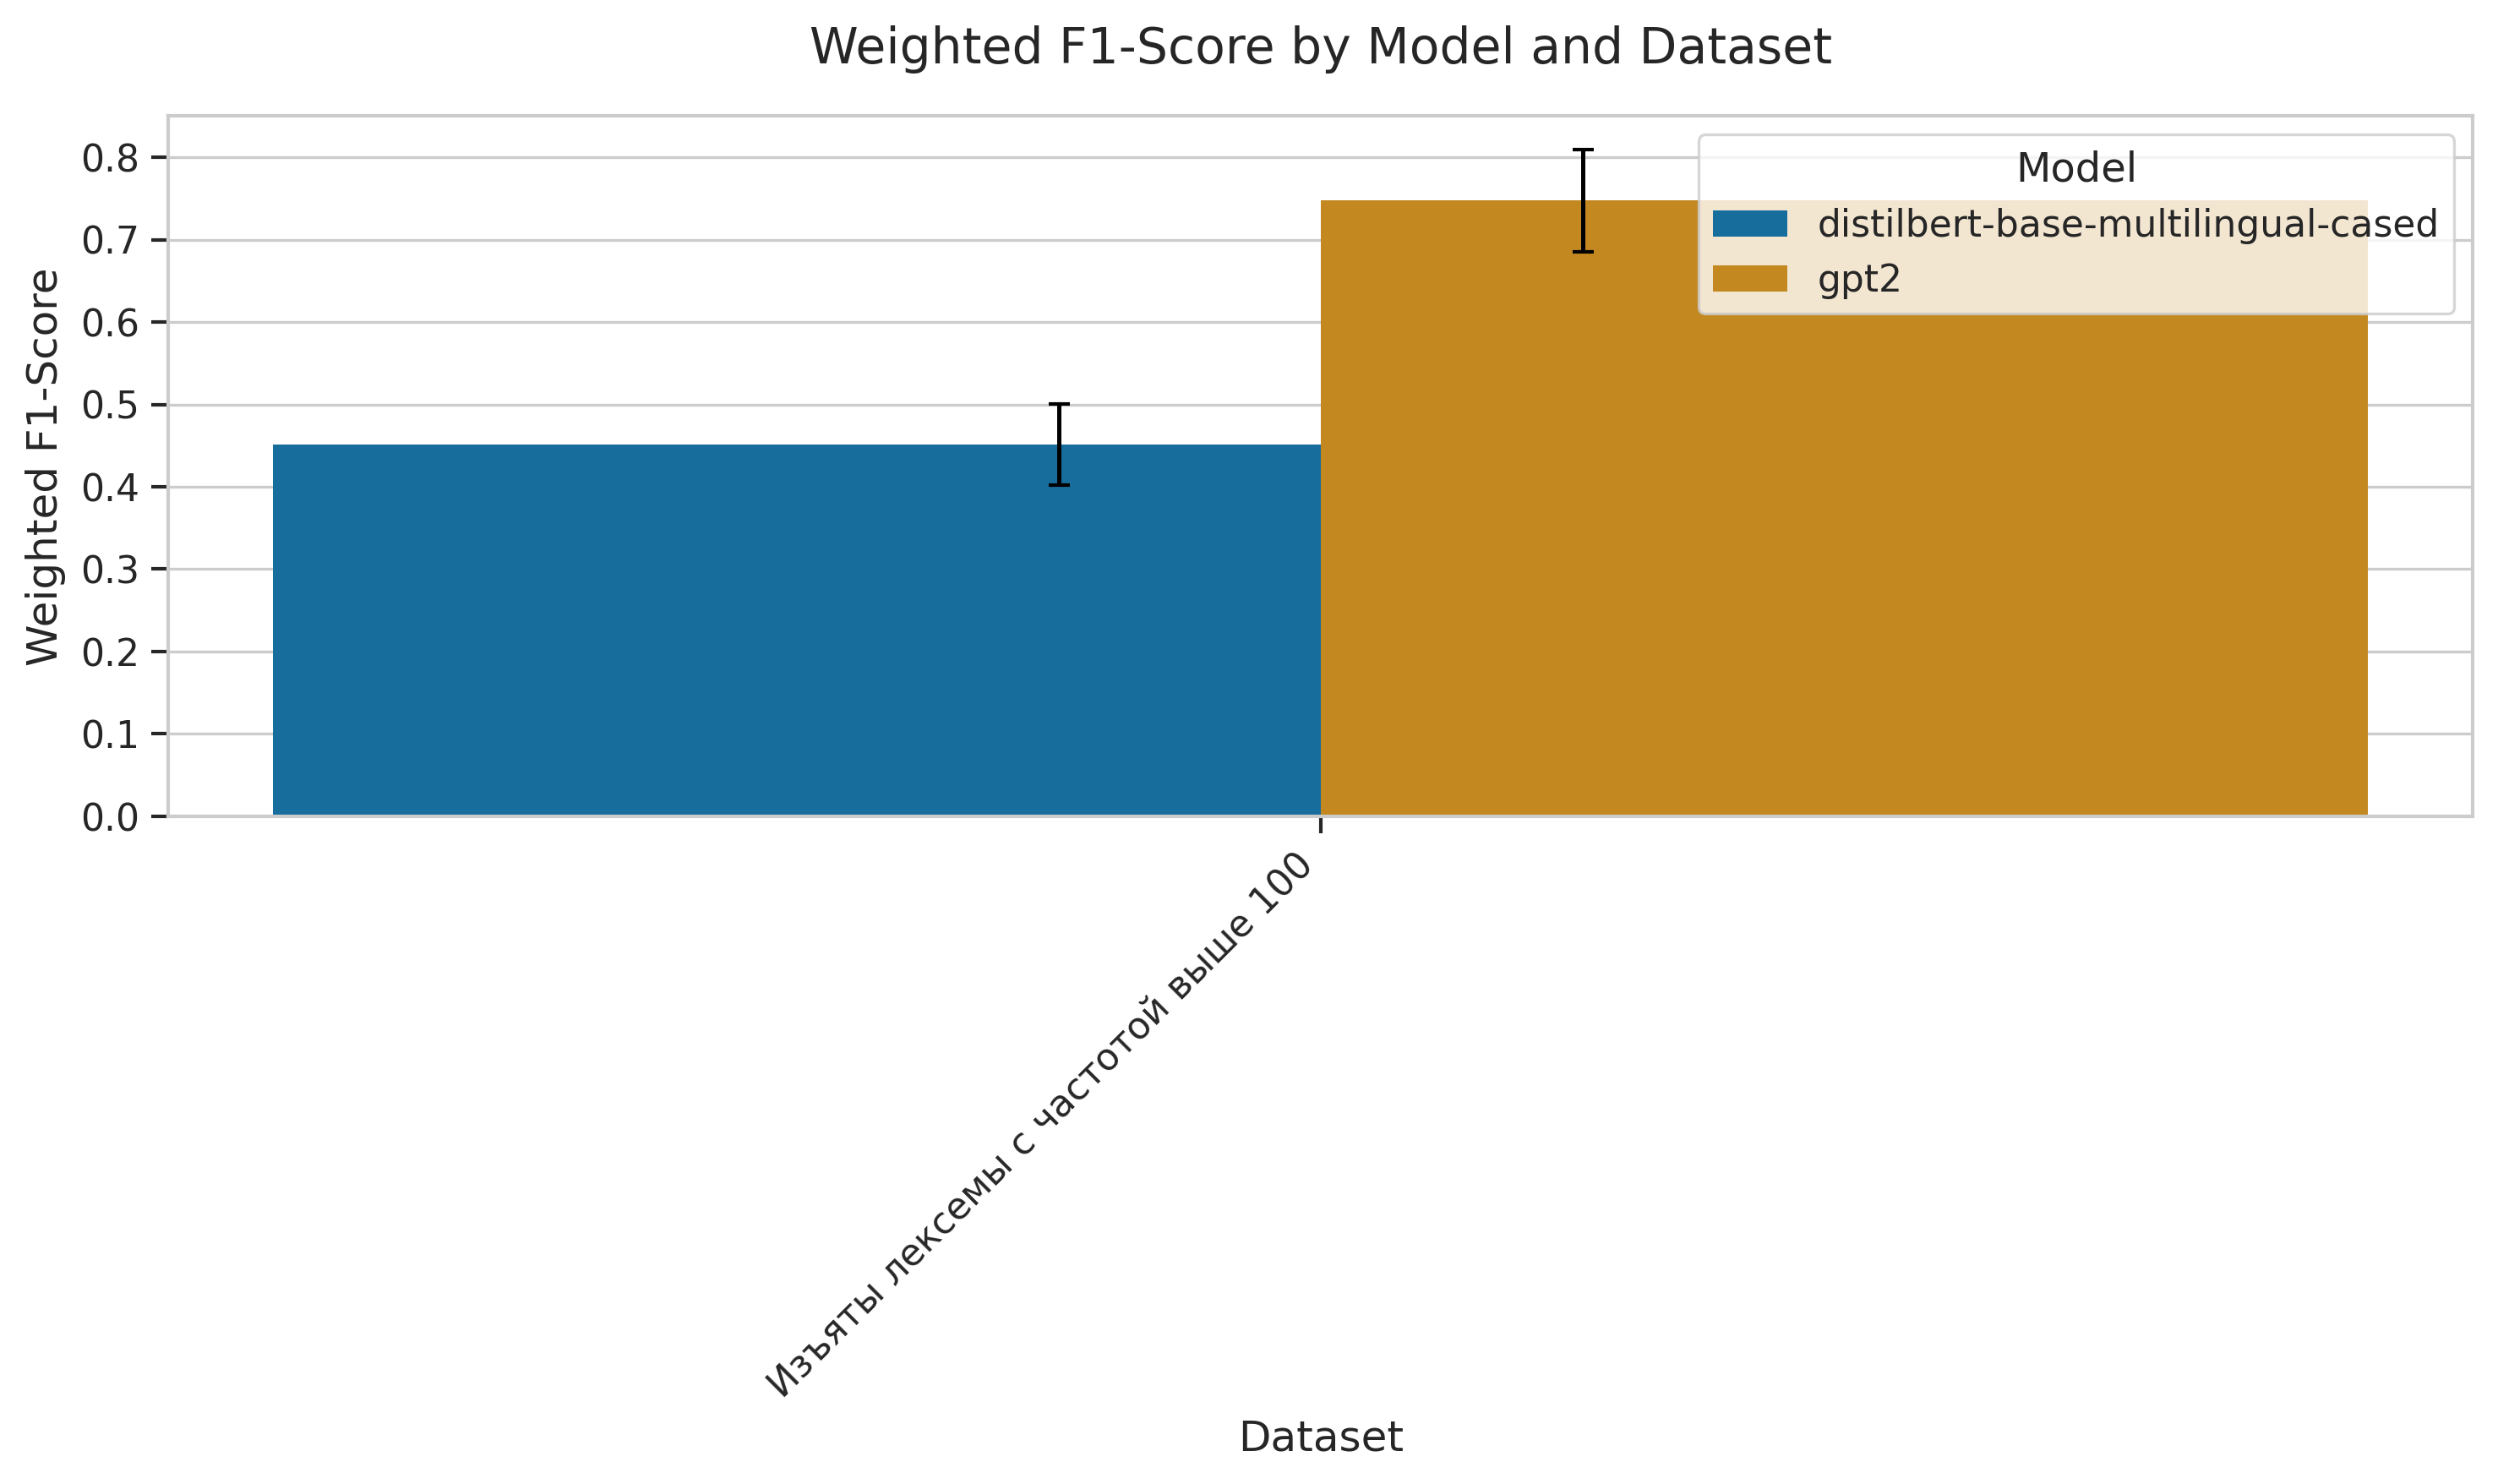

/tmp/ipykernel_5313/2563882205.py:43: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(x='dataset_name', y='f1_class1', hue='model_name', data=df,


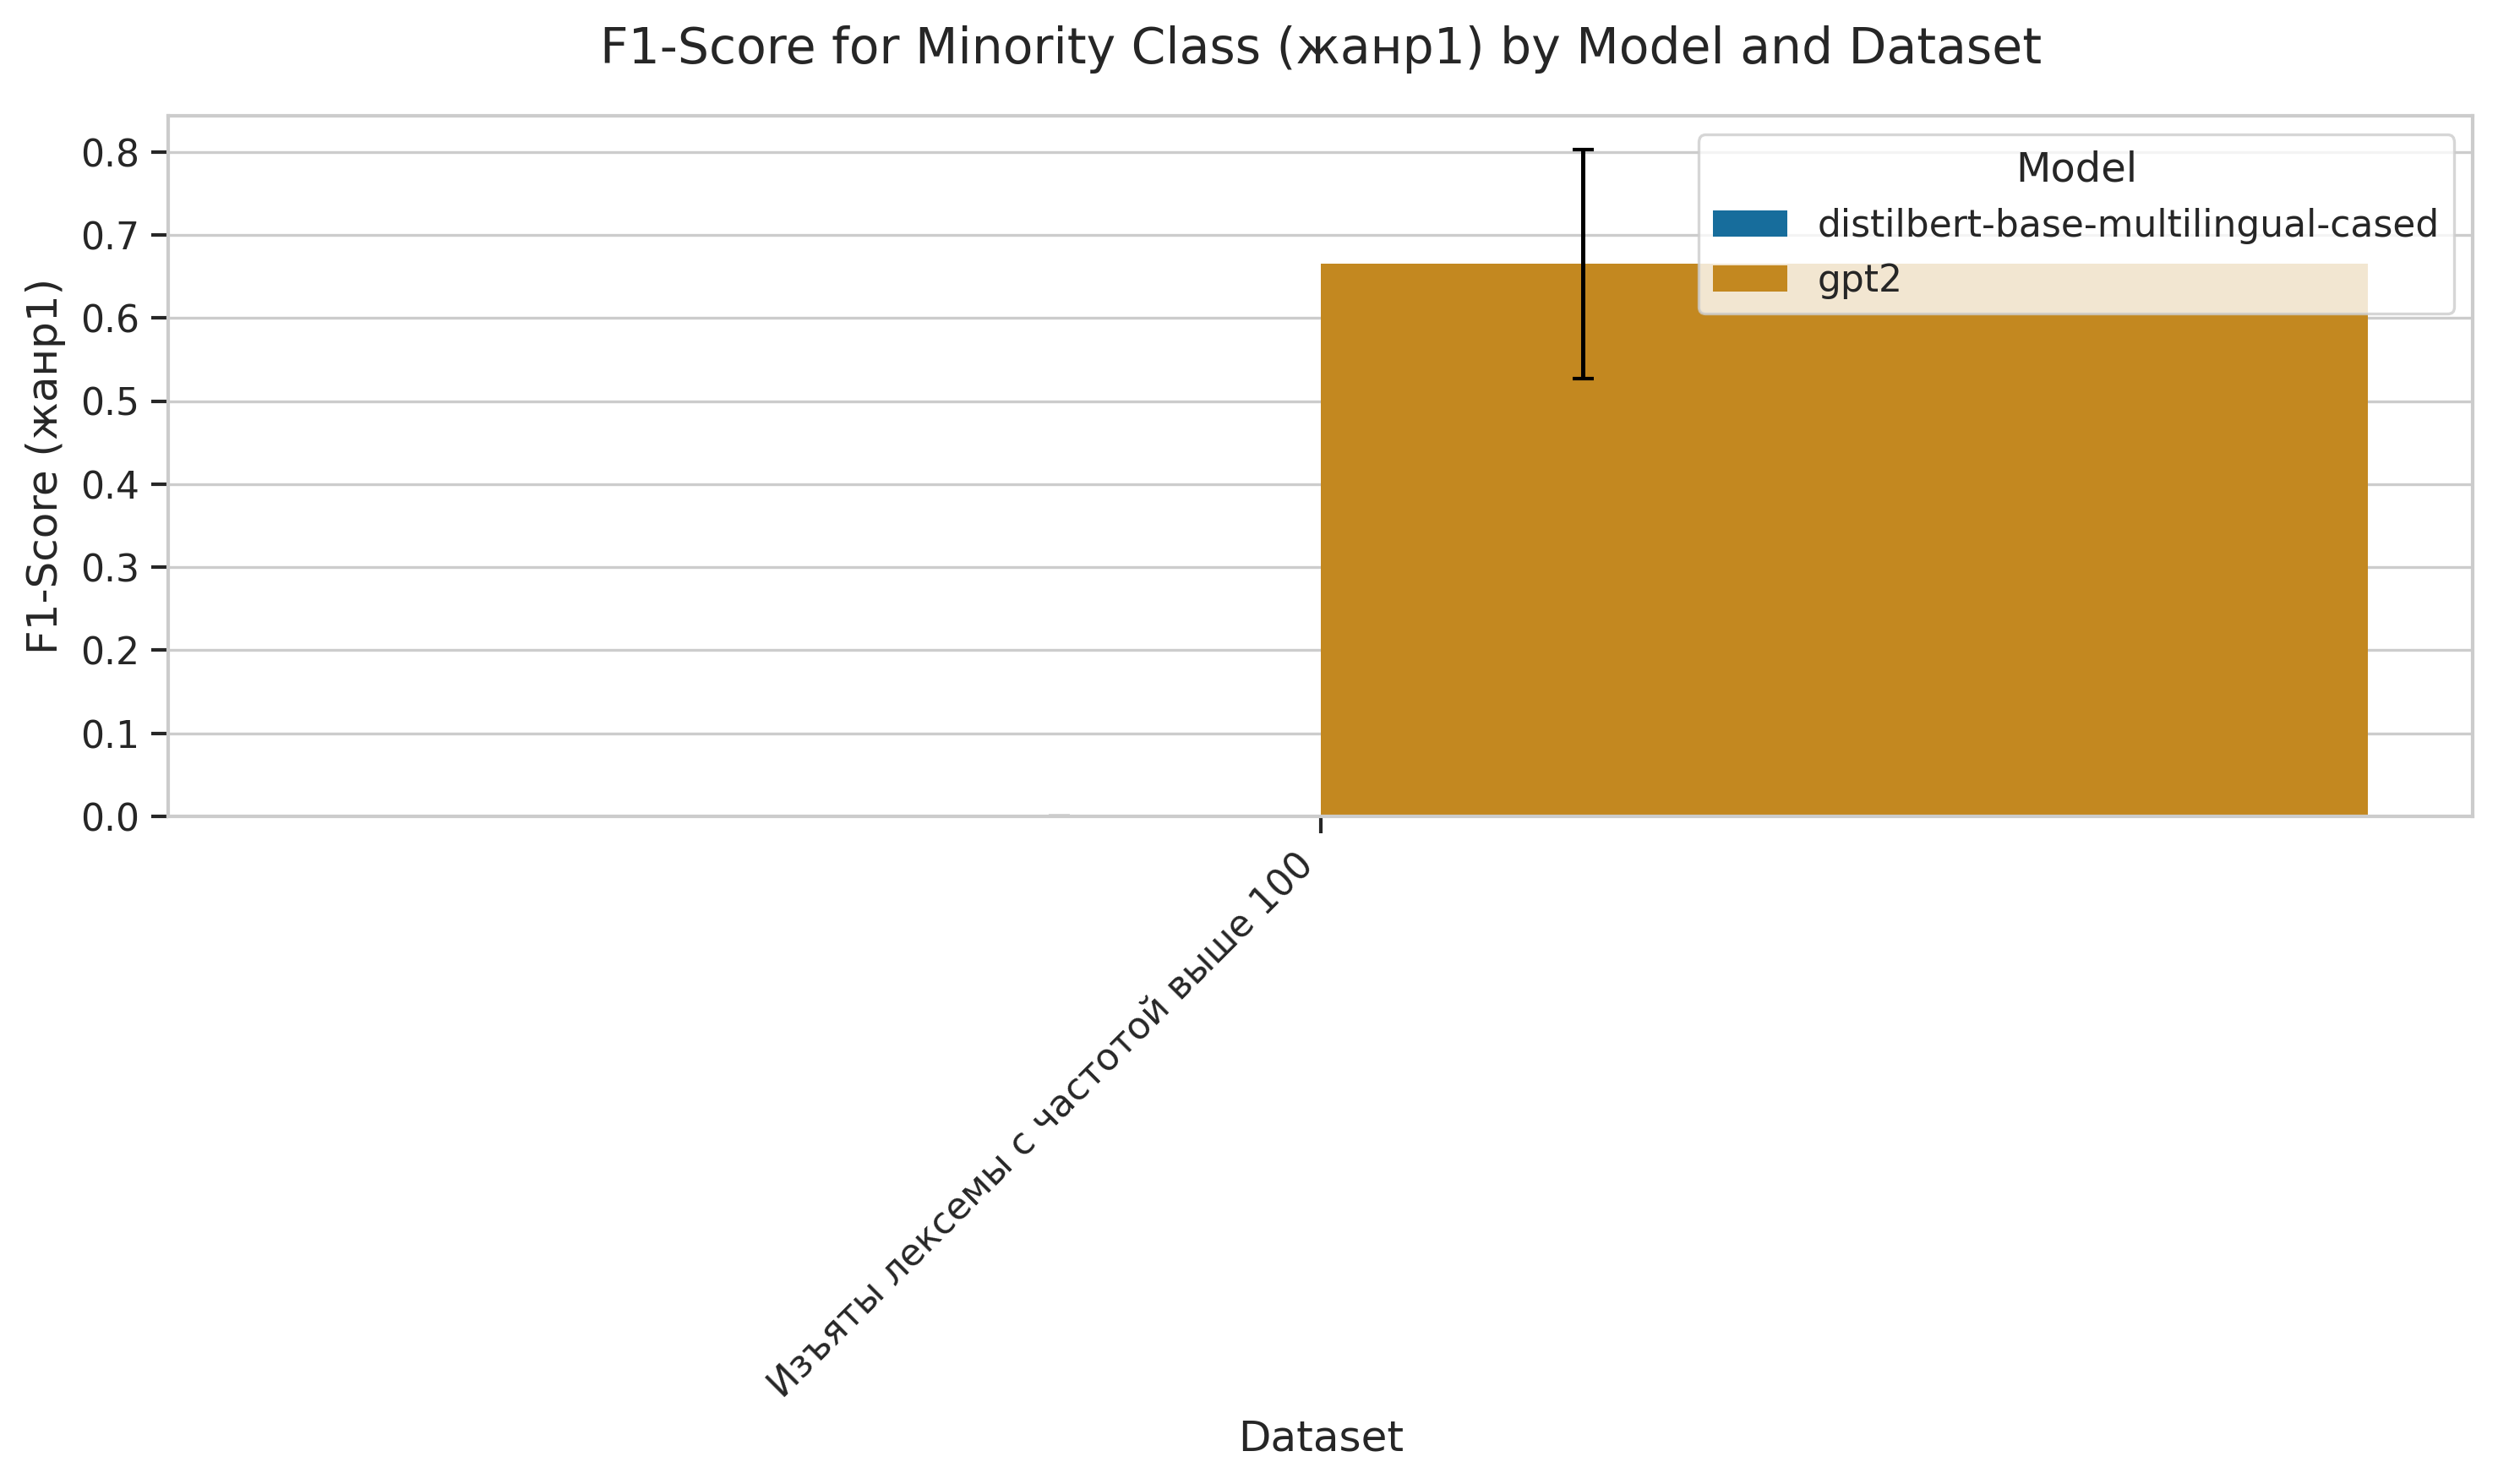

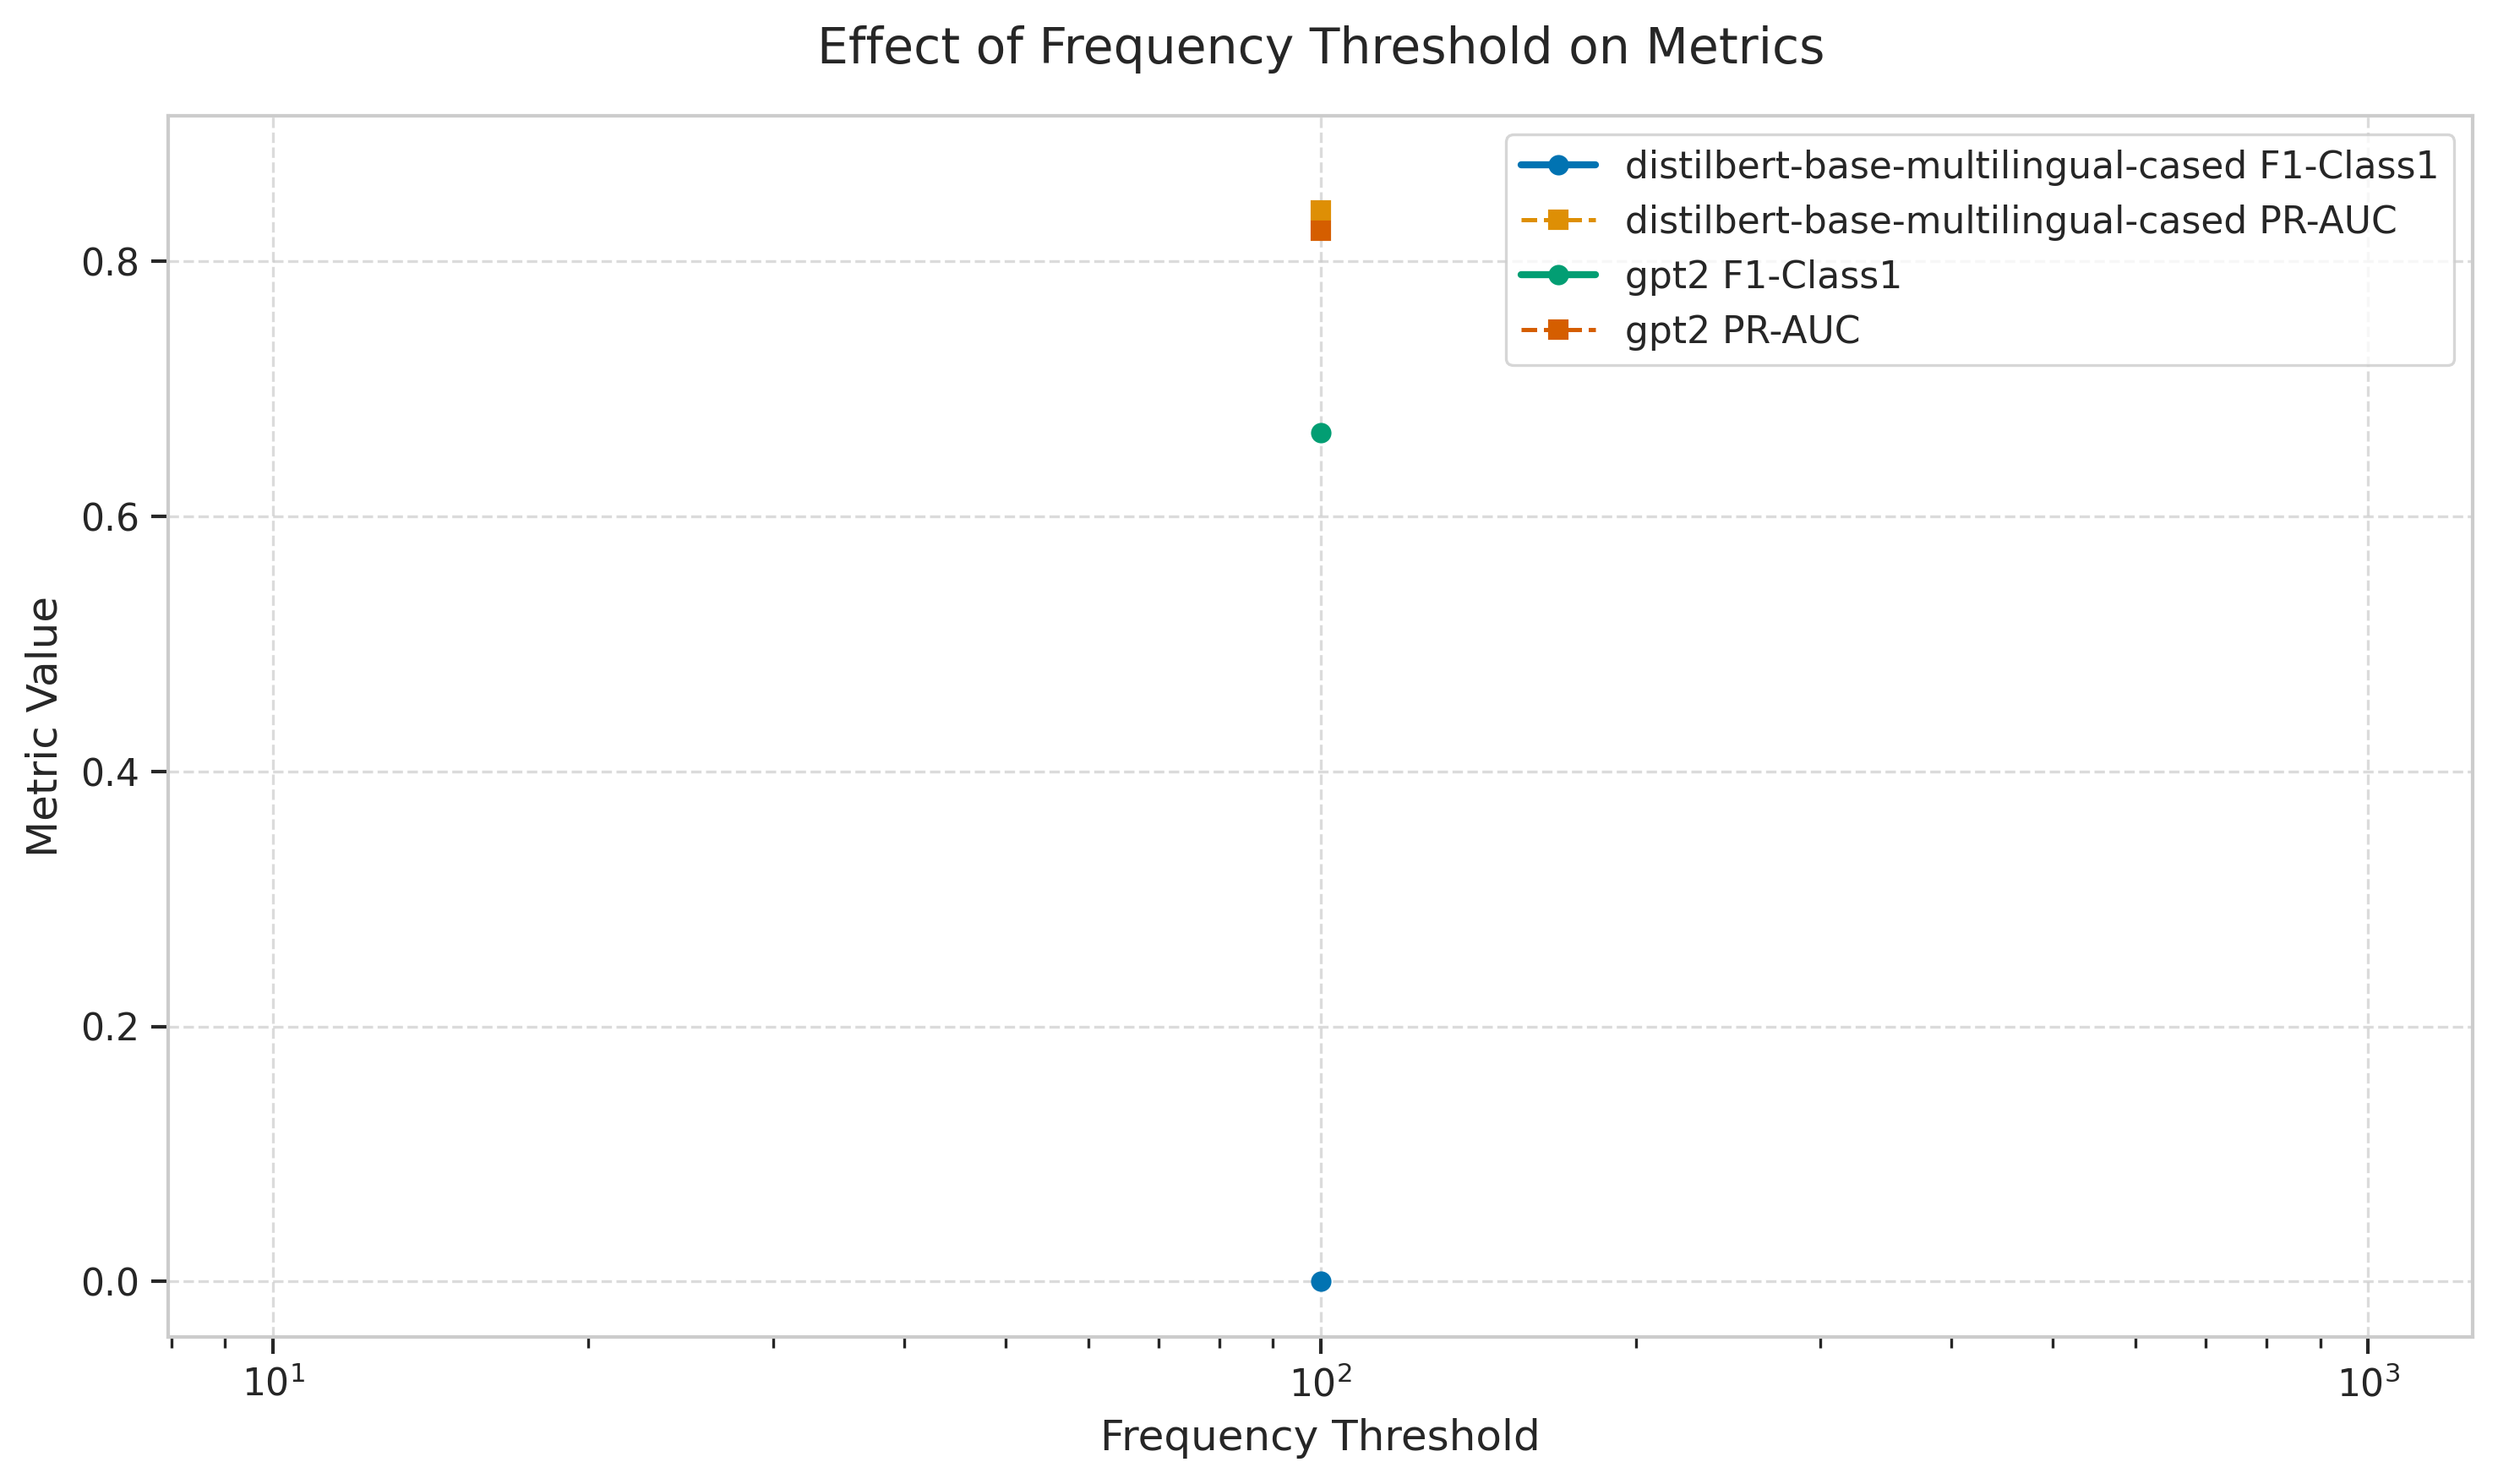

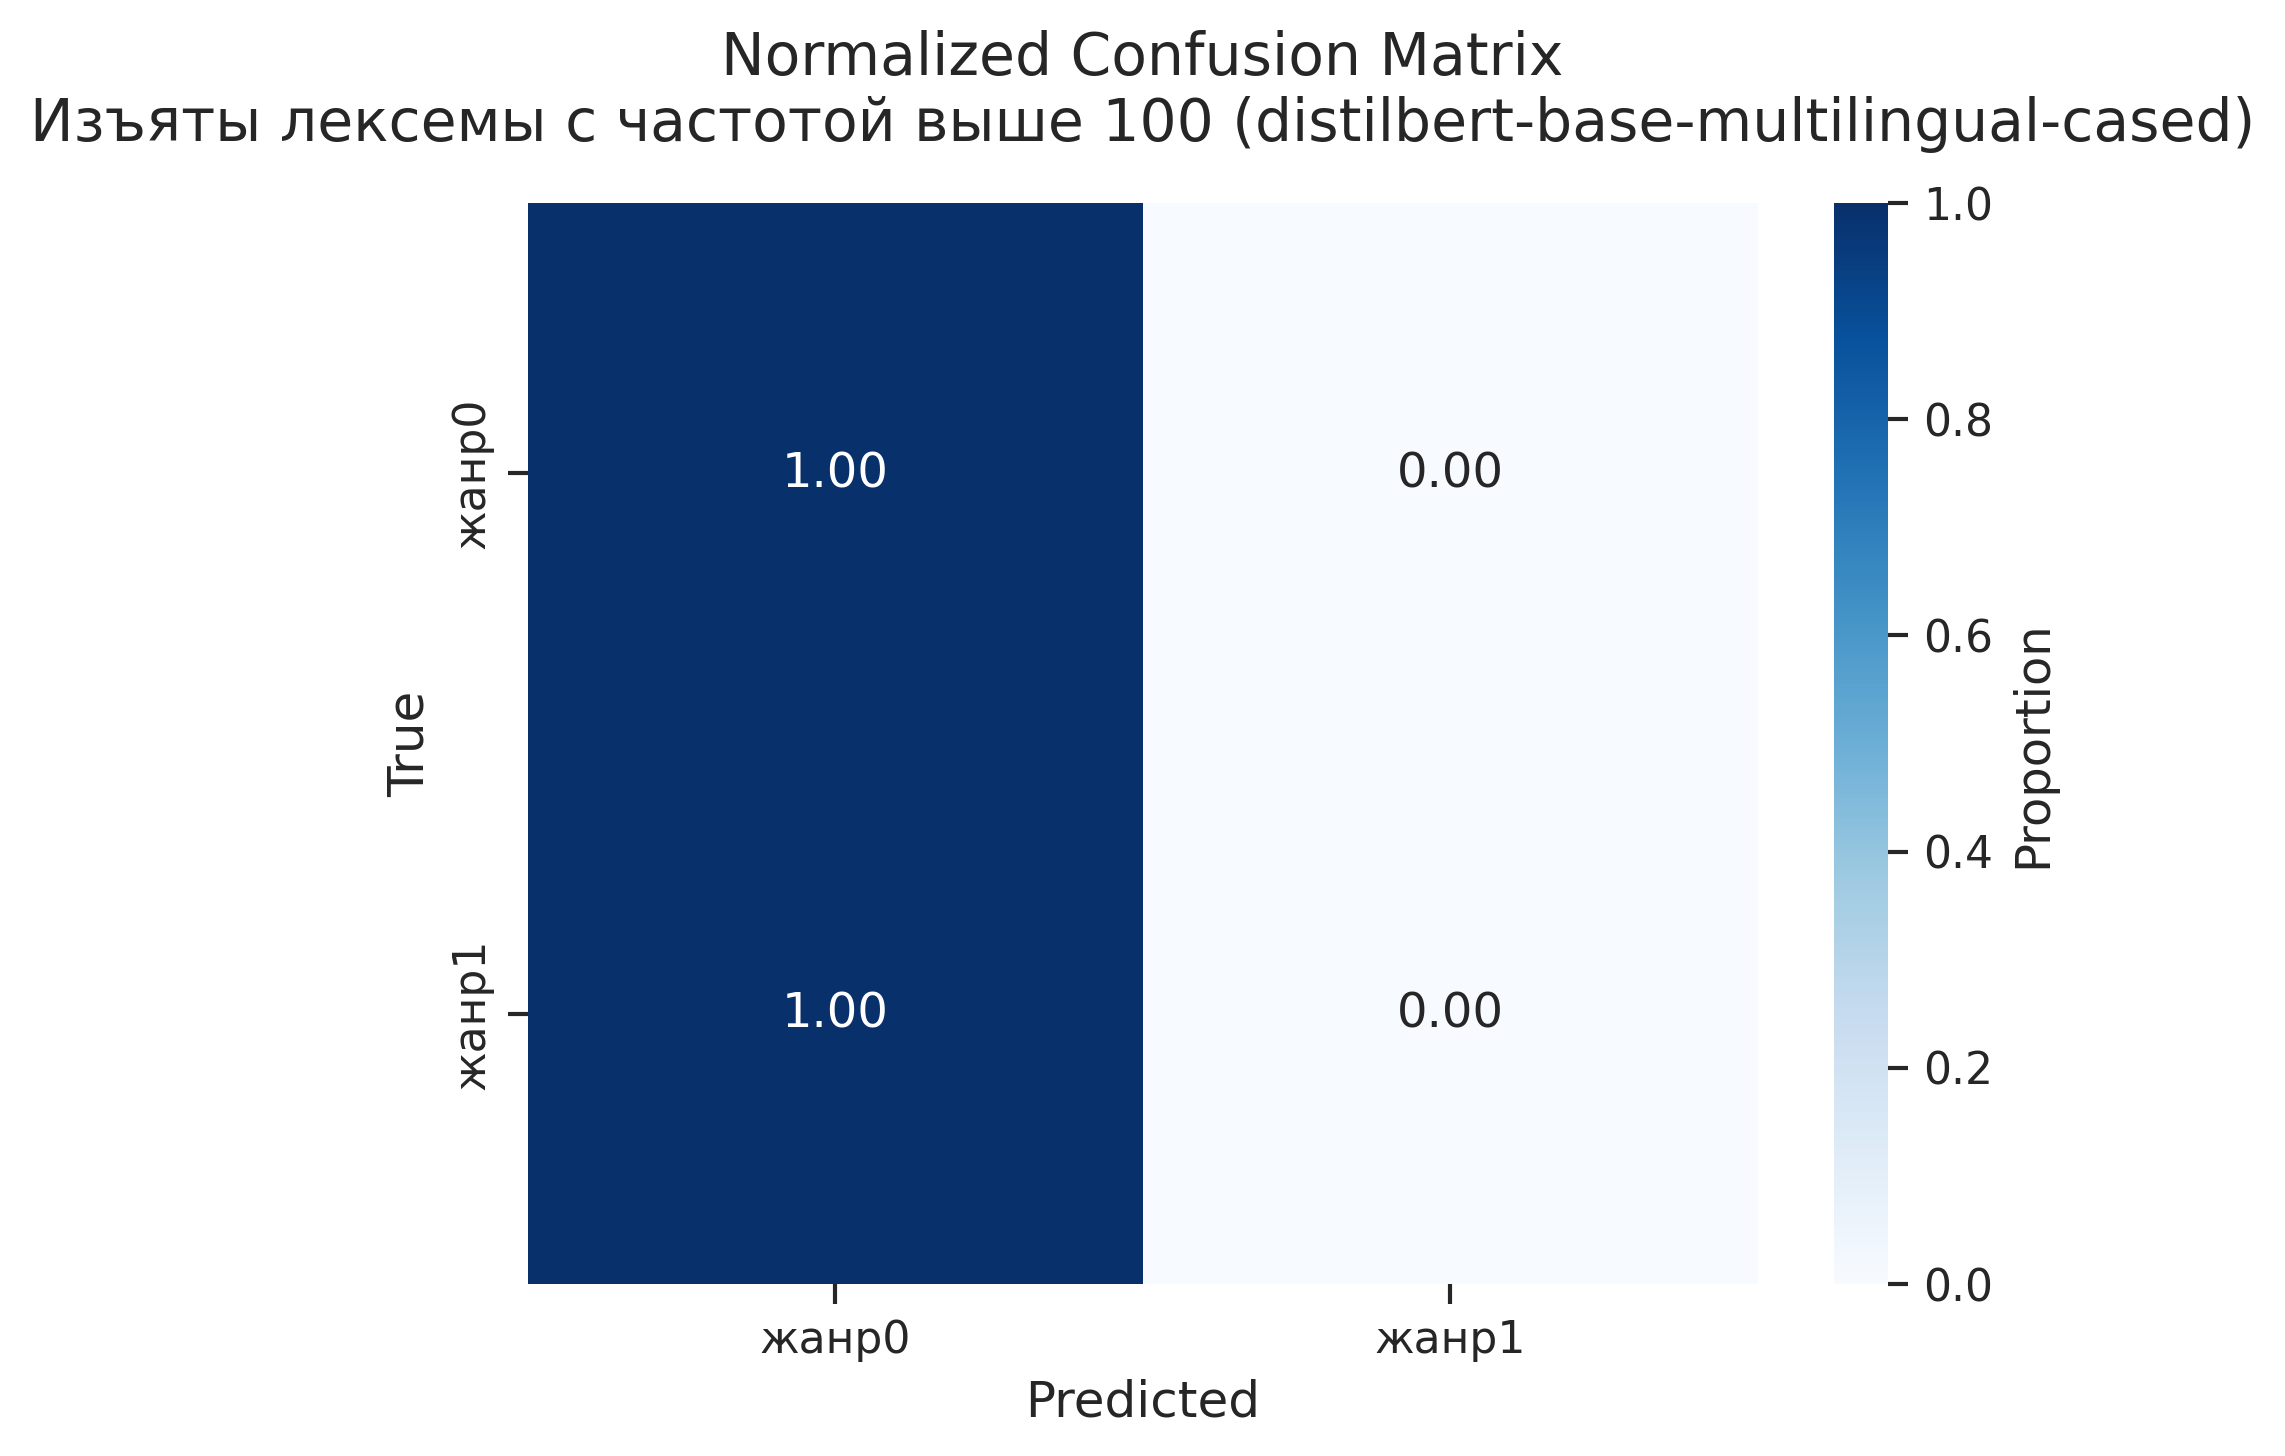

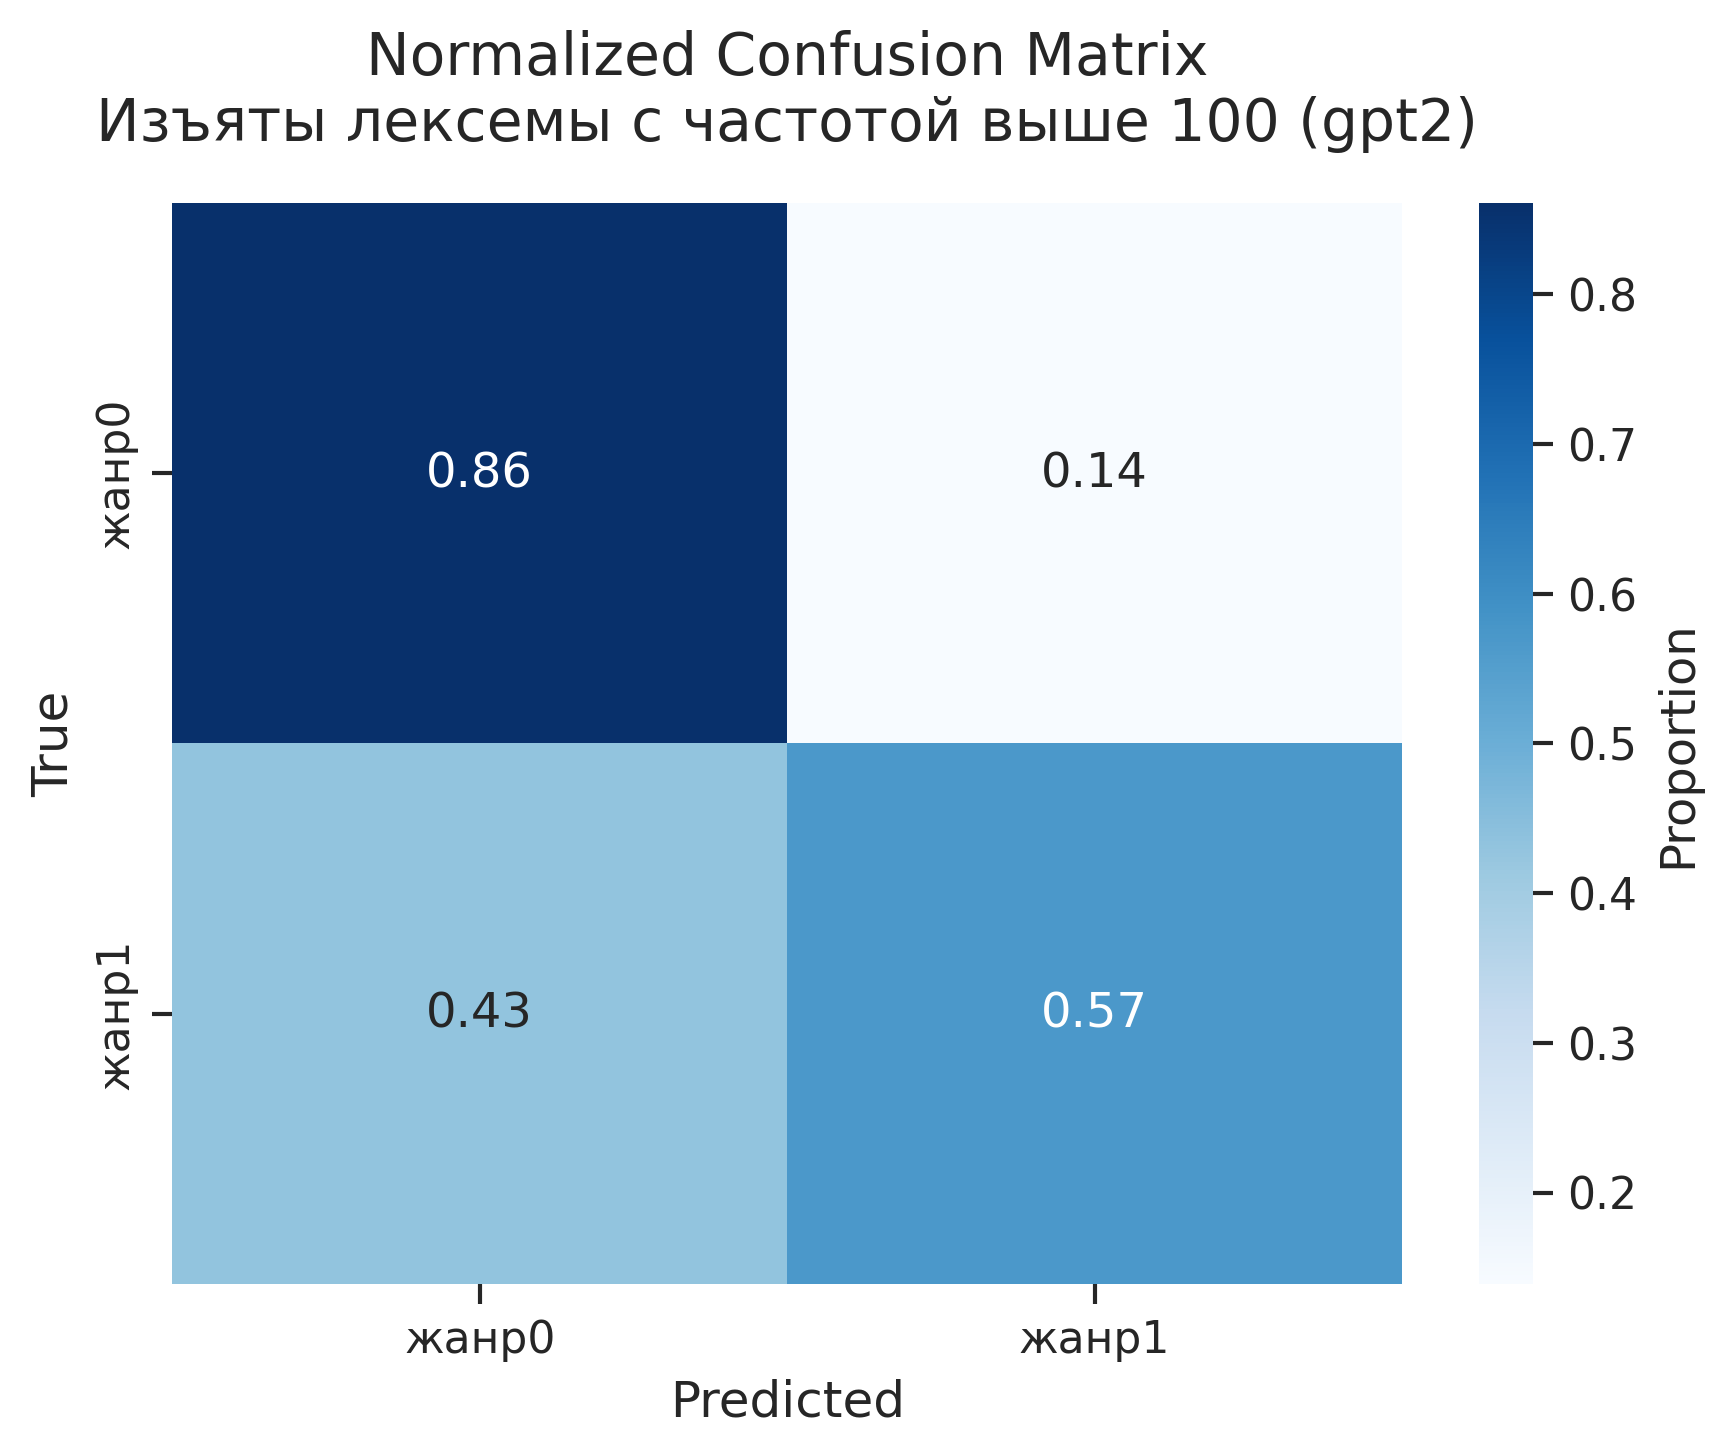

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import os
from sklearn.metrics import confusion_matrix

# Configuración de estilo profesional
plt.style.use('seaborn-v0_8-whitegrid')  # Estilo limpio
sns.set_context('paper', font_scale=1.2)  # Escala para informes
sns.set_palette('colorblind')  # Paleta profesional y accesible
plt.rcParams['font.family'] = 'sans-serif'  # Usar familia genérica
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Helvetica', 'Arial']  # Priorizar fuentes disponibles
plt.rcParams['figure.dpi'] = 300  # Alta resolución
plt.rcParams['savefig.dpi'] = 300

def plot_model_comparison(df, output_dir='plots'):
    """Gráfico de barras para comparar F1_weighted y F1_class1 entre modelos."""
    os.makedirs(output_dir, exist_ok=True)
    
    # Gráfico para F1_weighted
    plt.figure(figsize=(10, 6))
    sns.barplot(x='dataset_name', y='f1_weighted', hue='model_name', data=df, 
                capsize=0.1, errwidth=1.5, errorbar=None)
    for i, model in enumerate(df['model_name'].unique()):
        model_data = df[df['model_name'] == model]
        plt.errorbar(x=np.arange(len(model_data)) + i*0.2 - 0.1, 
                     y=model_data['f1_weighted'], 
                     yerr=model_data['std_f1_weighted'], 
                     fmt='none', c='black', capsize=3)
    plt.title('Weighted F1-Score by Model and Dataset', fontsize=14, pad=15)
    plt.xlabel('Dataset', fontsize=12)
    plt.ylabel('Weighted F1-Score', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Model', loc='upper right', frameon=True)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/f1_weighted_comparison.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    
    # Gráfico para F1_class1
    plt.figure(figsize=(10, 6))
    sns.barplot(x='dataset_name', y='f1_class1', hue='model_name', data=df, 
                capsize=0.1, errwidth=1.5, errorbar=None)
    for i, model in enumerate(df['model_name'].unique()):
        model_data = df[df['model_name'] == model]
        plt.errorbar(x=np.arange(len(model_data)) + i*0.2 - 0.1, 
                     y=model_data['f1_class1'], 
                     yerr=model_data['std_f1_class1'], 
                     fmt='none', c='black', capsize=3)
    plt.title('F1-Score for Minority Class (жанр1) by Model and Dataset', fontsize=14, pad=15)
    plt.xlabel('Dataset', fontsize=12)
    plt.ylabel('F1-Score (жанр1)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Model', loc='upper right', frameon=True)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/f1_class1_comparison.pdf', format='pdf', bbox_inches='tight')
    plt.show()

def plot_frequency_effect(df, output_dir='plots'):
    """Gráfico de líneas para el efecto de los umbrales de frecuencia."""
    os.makedirs(output_dir, exist_ok=True)
    freq_data = df[df['dataset_name'].str.contains('Изъяты лексемы')]
    if freq_data.empty:
        print("No se encontraron datasets de frecuencia en los datos.")
        return
    
    freq_data['freq'] = freq_data['dataset_name'].str.extract(r'выше (\d+)').astype(int)
    
    plt.figure(figsize=(10, 6))
    for model in freq_data['model_name'].unique():
        model_data = freq_data[freq_data['model_name'] == model].sort_values('freq')
        plt.plot(model_data['freq'], model_data['f1_class1'], marker='o', linewidth=2, label=f'{model} F1-Class1')
        plt.fill_between(model_data['freq'], 
                         model_data['f1_class1'] - model_data['std_f1_class1'], 
                         model_data['f1_class1'] + model_data['std_f1_class1'], 
                         alpha=0.2)
        plt.plot(model_data['freq'], model_data['pr_auc'], marker='s', linestyle='--', label=f'{model} PR-AUC')
        plt.fill_between(model_data['freq'], 
                         model_data['pr_auc'] - model_data['std_pr_auc'], 
                         model_data['pr_auc'] + model_data['std_pr_auc'], 
                         alpha=0.2)
    plt.title('Effect of Frequency Threshold on Metrics', fontsize=14, pad=15)
    plt.xlabel('Frequency Threshold', fontsize=12)
    plt.ylabel('Metric Value', fontsize=12)
    plt.xscale('log')
    plt.legend(loc='upper right', frameon=True)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/freq_effect.pdf', format='pdf', bbox_inches='tight')
    plt.show()

def plot_confusion_matrix(results, output_dir='plots'):
    """Gráfico de matriz de confusión normalizada."""
    os.makedirs(output_dir, exist_ok=True)
    
    for result in results:
        # Verificar si las claves necesarias están presentes
        if 'true_labels' not in result or 'predictions' not in result:
            print(f"Skipping confusion matrix for {result['dataset_name']} ({result['model_name']}): 'true_labels' or 'predictions' missing")
            continue
        
        true_labels = np.array(result['true_labels'])
        predictions = np.array(result['predictions'])
        dataset_name = result['dataset_name']
        model_name = result['model_name']
        
        cm = confusion_matrix(true_labels, predictions, normalize='true')
        
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', 
                    xticklabels=['жанр0', 'жанр1'], yticklabels=['жанр0', 'жанр1'], 
                    cbar_kws={'label': 'Proportion'})
        plt.title(f'Normalized Confusion Matrix\n{dataset_name} ({model_name})', fontsize=14, pad=15)
        plt.xlabel('Predicted', fontsize=12)
        plt.ylabel('True', fontsize=12)
        plt.tight_layout()
        plt.savefig(f'{output_dir}/cm_{dataset_name}_{model_name}.pdf', format='pdf', bbox_inches='tight')
        plt.show()

def generate_professional_plots(results_file, output_dir='plots'):
    """Genera todas las gráficas profesionales a partir del archivo JSON."""
    os.makedirs(output_dir, exist_ok=True)
    
    # Cargar resultados
    try:
        with open(results_file, 'r', encoding='utf-8') as f:
            results = json.load(f)
    except FileNotFoundError:
        print(f"Error: {results_file} not found.")
        return
    
    # Debug: Imprimir claves del primer resultado
    if results:
        print("Keys in first result:", results[0].keys())
    
    # Convertir a DataFrame
    data = []
    for result in results:
        data.append({
            'dataset_name': result['dataset_name'],
            'model_name': result['model_name'],
            'f1_weighted': result['avg_f1_weighted'],
            'std_f1_weighted': result['std_f1_weighted'],
            'f1_class1': result['avg_f1_class1'],
            'std_f1_class1': result['std_f1_class1'],
            'pr_auc': result['avg_pr_auc'],
            'std_pr_auc': result['std_pr_auc']
        })
    df = pd.DataFrame(data)
    
    # Generar gráficas
    plot_model_comparison(df, output_dir)
    plot_frequency_effect(df, output_dir)
    plot_confusion_matrix(results, output_dir)

# Ejecutar
if __name__ == "__main__":
    generate_professional_plots('model_results_GPT_bert.json', output_dir='plots')